<!-- ~ovn! -->
# Functional Programming

In [1]:
# Pure functions

f = lambda x: x**2

def fib(n):
    if n < 2:
        return n
    else:
        return fib(n-1) + fib(n-2)
    
fib(10)

55

In [2]:
# Functional programming with lists
# Functional programming languages like Haskell don't have loops
# Instead, they use recursion and higher-order functions
def mysum(xs):
    if not xs:
        return 0.0
    else:
        return xs[0] + mysum(xs[1:])

mysum([1,2,3,4,5])

15.0

## Functions are first-class objects

In functional programming can have pure functions that take other functions as arguments. This is called a higher-order function.

In [3]:
# Map
def mymap(x, f):
    if not x:
        return []
    else:
        return [f(x[0])] + mymap(x[1:], f)
    
# Here is how it works:
mymap([1,2,3,4,5], lambda x: x**2)

[1, 4, 9, 16, 25]

In [4]:
mymap([1,2,3,4,5], lambda x: x**3)

[1, 8, 27, 64, 125]

## Vectorization (vmap)
With `map` we can make a function that vectorizes another function, say `vmap`:

In [5]:
myvmap = lambda f: lambda x: mymap(x, f)

vectorized_square = myvmap(lambda x: x**2)

In [6]:
# reduce
def myreduce(x, f, init):
    if not x:
        return init
    elif len(x) == 1:
        return x[0]
    else:
        return f(x[0], myreduce(x[1:], f, init))
    
mysum_reduce = lambda x: myreduce(x, lambda x, y: x + y, 0)

mysum_reduce([1,2,3,4,5])

15

In [7]:
myprod_reduce = lambda x: myreduce(x, lambda x, y: x * y, 1)

myprod_reduce([1,2,3,4,5])

120

In [8]:
# filter 
# takes a function and a list and returns a list of elements that satisfy the function

def myfilter(x, f):
    if not x:
        return []
    elif f(x[0]):
        return [x[0]] + myfilter(x[1:], f)
    else:
        return myfilter(x[1:], f)

In [9]:
filter_even_numbers = lambda x: myfilter(x, lambda x: x % 2 == 0)

filter_even_numbers([1,2,3,4,5,6,7,8,9,10])

[2, 4, 6, 8, 10]

In functional programming languages, currying is used a lot. Syntax is nicer.
For example in Haskell, we can write:

```haskell
add :: Int -> Int -> Int
add x y = x + y

add2 :: Int -> Int
add2 = add 2
-- In GHCi
add2 3
>>> 5
```

## Function composition
Suppose you have two function `f` and `g`, such that the output of `g` is of the right type to be an input to `f`.
This allows you to compose them to make a new function `h`.
Mathematically we write, $h = f \circ g$, for function composition.

In [10]:
compose = lambda f, g: lambda x: f(g(x))

g = lambda x: x**2
f = lambda x: x + 1
h = compose(f, g)

print(f"h(x)\t= {h(2)}")
print(f"f(g(x))\t= {f(g(2))}")

h(x)	= 5
f(g(x))	= 5


Composition is nicer in Haskell

```haskell
f :: Int -> Int
f x = x + 1

g :: Int -> Int
g x = x ^ 2

h :: Int -> Int
h = f . g

h 3 -- 7
```

In [11]:
import dis

@myvmap
def g(x):
    return x**3
g([1,2,3,4,5])


[1, 8, 27, 64, 125]

In [12]:
dis.dis(g) # What does Cpython disassemble a decorator to be?

  1           0 LOAD_GLOBAL              0 (mymap)
              2 LOAD_FAST                0 (x)
              4 LOAD_DEREF               0 (f)
              6 CALL_FUNCTION            2
              8 RETURN_VALUE


# Just in Time Compilation

Python is an interpreted language and hence it is quite slow.

Previous methods attempt to provide `ffi` to C so that you can call C-functions from your Python code.
But this is cumbersome and error-prone.

**An** alternate solution is just-in-time (JIT) compilers, which is done by `jax`, which we care deeply about in machine learning.

It is built on top of XLA, which is a compiler for linear algebra operations developed at Google.

Lets do some `jax`!

In [13]:
import jax
import jax.numpy as jnp

In [14]:
# a simple math function
f = lambda x: jnp.sin(x) + jnp.cos(x)

# A jit-compiled version of the function
f_jit = jax.jit(f)

# It can be used as a decorator as well
@jax.jit
def f_jit2(x):
    return jnp.sin(x) + jnp.cos(x)

f(2)

Array(0.49315056, dtype=float32, weak_type=True)

In [15]:
f_jit2(2)

Array(0.49315056, dtype=float32, weak_type=True)

There is no real benefit in this case, because the function is simple.
However, when we `jit` bigger chunks of code, e.g., the update step in the training loop of a NN, there is significant speedup.

**However you can only jit _pure_ functions**. _Pure functions_ are functions with no side-effects.

## Be careful with loops in `jax`

`jit` works with loops, only if we have a fixed number of iterations that is known at compile time. 
This is to know how many times to unroll the loop.

In [16]:
@jax.jit
def f_loop(x):
    y = 0.
    for i in range(10):
        y = y + x
    return y

f_loop(2)

Array(20., dtype=float32, weak_type=True)

In [17]:
@jax.jit
def f_loop(x, n):
    y = 0.
    for i in range(n):
        y = y + x
    return y
f_loop(2, 10)

TracerIntegerConversionError: The __index__() method was called on traced array with shape int32[].
The error occurred while tracing the function f_loop at /var/folders/p9/0clmpgx106ngs3bfxpjdlkjh0000gn/T/ipykernel_53111/3378156147.py:1 for jit. This concrete value was not available in Python because it depends on the value of the argument n.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerIntegerConversionError

To make this work in `jax`, we must tell `jax` that the second argument is a constant and it must not trace it.
We can make it work using `functools.partial` 

In [18]:
import functools as ft

@ft.partial(jax.jit, static_argnums=(1,))
def f_loop(x, n):
    y = 0.
    for i in range(n):
        y = y + x
    return y

f_loop(2, 10) # magic!

Array(20., dtype=float32, weak_type=True)

This is alright if we are going to call `f_loop` with only a few few different values of `n`.
This is not okay, if we are calling `f_loop` with many different `n`'s, because the re-compilation will cause unnecessary delays.

If we want to avoid the recompilation, we need to use a Lax control primitive. 
Lax is a low-level API for Jax.

In [19]:
from jax import lax

@jax.jit
def f_loop(x, n):
    return lax.fori_loop(0, n, lambda i, y: y + x, 0.)

f_loop(2, 10)

Array(20., dtype=float32, weak_type=True)

In [20]:
# Other useful functions are lax.while_loop, which implements a while loop
@jax.jit
def sum_up_to(x):
    s = 0.0
    n = 1
    while n < x:
        s = s + n
        n = n + 1
    return s
sum_up_to(10)

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function sum_up_to at /var/folders/p9/0clmpgx106ngs3bfxpjdlkjh0000gn/T/ipykernel_53111/2766001324.py:2 for jit. This concrete value was not available in Python because it depends on the value of the argument x.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [21]:
@jax.jit
def sum_up_to(x):
    return lax.while_loop(
        lambda c: c[1] <= x,
        lambda c: (c[0] + c[1], c[1] + 1),
        (0, 1)      # initial values, c0 = 0, c1 = 1
    )[0]
sum_up_to(10)

Array(55, dtype=int32, weak_type=True)

In [22]:
# One has to be careful with conditionals as well
@jax.jit
def myabs(x):
    if x < 0:
        return -x
    else:
        return x
myabs(-1)

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function myabs at /var/folders/p9/0clmpgx106ngs3bfxpjdlkjh0000gn/T/ipykernel_53111/3500392006.py:2 for jit. This concrete value was not available in Python because it depends on the value of the argument x.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [23]:
# Need to use `lax.cond` instead
@jax.jit
def myabs(x):
    return lax.cond(x < 0,          # condition
                    lambda _: -x,   # if true
                    lambda _: x,    # if false
                    None            # operands to pass to the lambda functions
                )
myabs(-1)

Array(1, dtype=int32, weak_type=True)

In [24]:
# another lax primitive suggested is `lax.switch`
def fa():
    return jax.debug.print("a")

def fb():
    return jax.debug.print("b")

def fc():
    return jax.debug.print("c")

list_of_functions = [fa, fb, fc]
lax.switch(0, list_of_functions)

a


## Vectorization
`jax` replaces Numpy arrays and functions with `jax` arrays and functions.
This allows `jax` to automatically calculate gradients and other derivative and to compule functions for faster execution.
`jax` arrays are immutable, unlike `numpy` arrays.
For example, `+=` operatiion is not supported for `jax` arrays.

Vectorization takes a function that works on single values and turns it into a function that works on arrays.
This is useful because it allows us to write code that is more concise and often faster.

Lets understand with radial basis functions

$$
f(x) = \sum_{i=1}^n w_i \phi_i(x)
$$
where $\phi_i(x) = \exp(-\frac{1}{2\sigma^2}||x - c_i||^2)$ is a radial basis function with center $c_i$ and $\sigma$ is the bandwidth parameter.

In [25]:
rbf = lambda x, c, sigma2: jnp.exp(-jnp.sum((x - c)** 2, axis=-1) / sigma2)

In [26]:
x = jnp.array([0.5])
c = jnp.array([0.0])
sigma2 = 0.1

rbf(x, c, sigma2)

Array(0.082085, dtype=float32)

Now we want to vectorize it wrt the input $c_i$, so that we can pass all the centers at once. We can do this by using the `vmap` function:

In [27]:
from jax import vmap

phi = vmap(rbf, in_axes=(None, 0, None), out_axes=0)
# Arguments of `vmap` are:
# 1- the function to be vectorized
# 2- the axes of the input that should be mapped over. 
#    `0` means that we want to vectorize wrt to the first dimension of `c`
# 3- the `out_axes` describes how we want to vectorize the output.
#    `0` means that we want to vectorize wrt to the first dimension of the output, as output is a scalar

In [28]:
centers = jnp.linspace(-1, 1, 10)
phi(x, centers, sigma2)

Array([1.6918980e-10, 8.1134310e-08, 1.4491094e-05, 9.6397504e-04,
       2.3883473e-02, 2.2039244e-01, 7.5746524e-01, 9.6960723e-01,
       4.6227053e-01, 8.2084998e-02], dtype=float32)

In [29]:
# trying it for 2d arrays
x_2d = jnp.array([0.5, 0.7])

# Here are the 2D centers
c1 = jnp.linspace(-1, 1, 10)
c2 = jnp.linspace(-1, 1, 10)
C = jnp.meshgrid(c1, c2)
print(C[0].shape)
centers = jnp.stack(C, axis=-1).reshape(-1, 2)
print(jnp.stack(C, axis=-1).shape)
print(centers.shape)

(10, 10)
(10, 10, 2)
(100, 2)


In [30]:
phi(x_2d, centers, sigma2)

Array([4.7562314e-23, 2.2808324e-20, 4.0737123e-18, 2.7099149e-16,
       6.7140702e-15, 6.1956259e-14, 2.1293739e-13, 2.7257452e-13,
       1.2995268e-13, 2.3075580e-14, 5.5479779e-20, 2.6605014e-17,
       4.7518256e-15, 3.1610093e-13, 7.8317292e-12, 7.2269815e-11,
       2.4838404e-10, 3.1794808e-10, 1.5158498e-10, 2.6916859e-11,
       2.4102930e-17, 1.1558467e-14, 2.0644120e-12, 1.3732855e-10,
       3.4024576e-09, 3.1397281e-08, 1.0790907e-07, 1.3813091e-07,
       6.5855374e-08, 1.1693903e-08, 3.9000916e-15, 1.8702704e-12,
       3.3404224e-10, 2.2221114e-08, 5.5055119e-07, 5.0803897e-06,
       1.7460752e-05, 2.2350945e-05, 1.0656060e-05, 1.8921869e-06,
       2.3504205e-13, 1.1271351e-10, 2.0131354e-08, 1.3391754e-06,
       3.3179396e-05, 3.0617364e-04, 1.0522862e-03, 1.3469983e-03,
       6.4219604e-04, 1.1403423e-04, 5.2757451e-12, 2.5299631e-09,
       4.5186761e-07, 3.0059076e-05, 7.4474415e-04, 6.8723680e-03,
       2.3619594e-02, 3.0234693e-02, 1.4414707e-02, 2.5596090e

In [31]:
# Now vectorizing wrt the first input, `x`
vphi = vmap(phi, in_axes=(0, None, None), out_axes=0)

In [32]:
xs = jnp.linspace(-1, 1, 100).reshape(-1, 1)
cs = jnp.linspace(-1, 1, 10).reshape(-1, 1)
phis = vphi(xs, cs, sigma2)
print(phis.shape)

(100, 10)


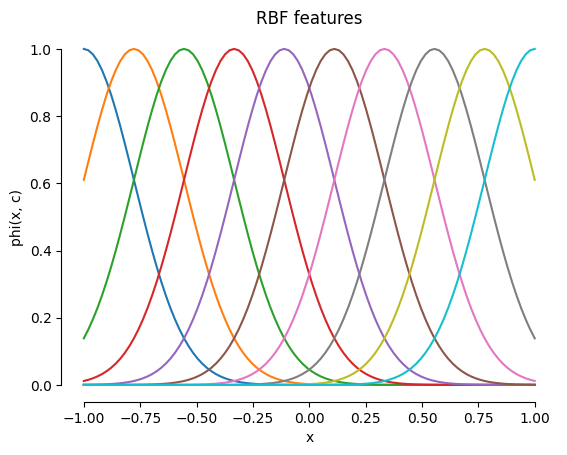

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
ax.plot(xs, phis)
ax.set(xlabel="x", ylabel="phi(x, c)", title="RBF features")
sns.despine(trim=True)

In [34]:
# same code works for 2D

x1 = jnp.linspace(-1, 1, 50)
x2 = jnp.linspace(-1, 1, 50)
X1, X2 = jnp.meshgrid(x1, x2)
X = jnp.stack((X1, X2), axis=-1).reshape(-1, 2)
print(X.shape)

print(centers.shape)

(2500, 2)
(100, 2)


In [35]:
phis = vphi(X, centers, sigma2)
phis.shape

(2500, 100)

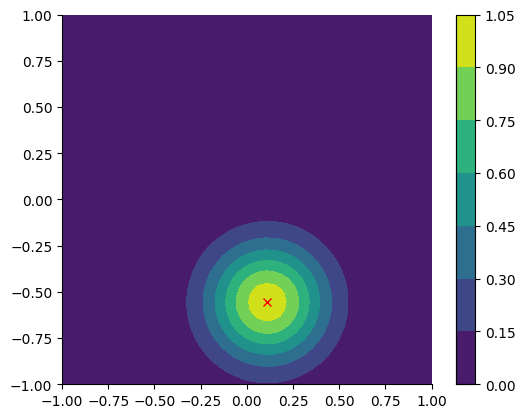

In [36]:
# contour plot of one of them
i = 25
fig, ax = plt.subplots()
ax.set_aspect("equal")
x = ax.contourf(X1, X2, phis[:, i].reshape(50, 50))
ax.plot(centers[i, 0], centers[i, 1], "rx")
plt.colorbar(x)
sns.despine(trim=True)

In [37]:
# Lets do the vectorization process described above in a single function

@jax.jit
@ft.partial(vmap, in_axes=(0, None, None), out_axes=0) # vectorize wrt to input `x`
@ft.partial(vmap, in_axes=(None, 0, None), out_axes=0) # vectorize wrt to input `c`
def rbf_basis(x, c, sigma2):
    return jnp.exp(-jnp.sum((x -c)**2) / sigma2)

# Now we can use it as a function
rbf_basis(X, centers, sigma2).shape

(2500, 100)

In [38]:
%timeit vphi(X, centers, sigma2).block_until_ready()

5.95 ms ± 81.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
%timeit rbf_basis(X, centers, sigma2).block_until_ready()
# @jax.jit is not giving me the same speed-up as it did in the tutorial
# Vector sizes seem to affect the compilation time, which is interesting. (maybe the dependence is on RAM?/Processor?)

811 µs ± 117 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Pseudo Random Numbers without Side Effects

`jax` uses pure functions. PRNGs are typically implemented as stateful objects.
- You initialize the generator with a seed
- You call the generator to get a random number
- The generator updates its internal state

Stateful objects wont work with `jax` because it violates the purity of the function.

In [40]:
# The state object is:
import jax.random as random

key = random.PRNGKey(0)
# It is a tuple of two 32-bit integers
key

Array([0, 0], dtype=uint32)

In [41]:
random.normal(key, shape=(2, 3))

Array([[ 0.18784384, -1.2833426 ,  0.6494181 ],
       [ 1.2490594 ,  0.24447003, -0.11744965]], dtype=float32)

In [42]:
# When sampling from a distribution, we explicitly pass the key. 
# Here is a sample from standard normal
random.normal(key, shape=(2, 2))

Array([[ 1.8160863 , -0.75488514],
       [ 0.33988908, -0.53483534]], dtype=float32)

In [43]:
key # key is unchanged

Array([0, 0], dtype=uint32)

In [44]:
# to get a different sample you need to `split` the key
key, subkey = random.split(key)


In [45]:
key

Array([4146024105,  967050713], dtype=uint32)

In [46]:
subkey

Array([2718843009, 1272950319], dtype=uint32)

In [47]:
random.normal(subkey, shape=(2, 2))

Array([[ 1.1378784 , -0.14331433],
       [-0.59153634,  0.79466224]], dtype=float32)

You must thread the key through your code. You get used to it when doing it a few times.

Generating samples from a random walk using functional programming.
The random walk starts at $x_0$:
$$
x_{t+1} = x_t + \sigma z_t,
$$
where $\sigma > 0$ and
$$
z_t \sim \mathcal{N}(0,1).
$$

In [48]:
def rw_step(x, sigma, key):
    """a single step of random walk"""
    key, subkey = random.split(key)
    return x + sigma * random.normal(subkey, shape=x.shape), key

In [77]:
# Now we can put it in a loop to take multiple steps and jit it
@ft.partial(jax.jit, static_argnums=(3,))
def sample_rw(x0, sigma, key, n_steps):
    """sample a random walk"""
    keys = random.split(key, n_steps)
    def step_random_walk(x_prev, key_prev):
        """Single step of random walk"""
        x_next = x_prev + sigma * random.normal(key_prev, shape=x_prev.shape)
        return x_next, x_prev
    carry, stack = lax.scan(step_random_walk, x0, keys, n_steps)
    return stack



In [81]:
walk = sample_rw(jnp.zeros(2), 1.0, key, 1_000_000)

In [82]:
walk.shape

(100000000, 2)

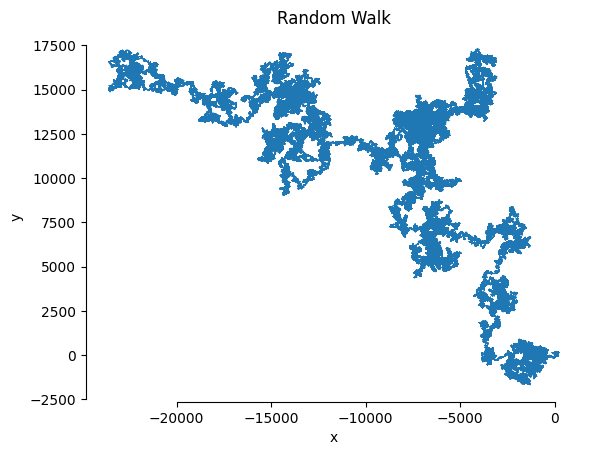

In [83]:
fig, ax = plt.subplots()
ax.plot(walk[:, 0], walk[:, 1], lw=0.5)
ax.set(xlabel="x", ylabel="y", title="Random Walk")
sns.despine(trim=True)